#Configuração de ambiente

**Criar cópia antes de executar as células de código!!**

In [1]:
import joblib
import sys
import os
from google.colab import output
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Escolhendo e carregando modelos

In [2]:
caminho_geral = '/content/drive/MyDrive/Programa - Repositório Institucional UFSC/Word Embeddings/Treinamento do nosso modelo/Treinamento com temporalização/HST'

#################### SELEÇÃO DAS PASTAS COM OS MODELOS TREINADOS COM TEMPORALIZAÇÃO ################################################################################
pasta_de_treinamento = '3 em 3 anos separando/Com Rec. de Entidades'


caminho = os.path.join(caminho_geral,pasta_de_treinamento)

modelos_treinados = []
modelos_treinados_armazenados = sorted([elemento for elemento in set(os.listdir(caminho)) if elemento.endswith('.joblib')])
for modelo in modelos_treinados_armazenados:
  modelos_treinados.append((str(modelo)[:(len(modelo)-7)].replace('modelo_','').replace('c_re_',' ').replace('s_re_',' ').strip().replace(' ','-'),joblib.load(os.path.join(caminho,modelo))))

print('Modelos encontrados:')
for modelo in modelos_treinados:
  print(modelo[0])

Modelos encontrados:
2010_2012
2013_2015
2016_2018
2019_2021
2022_2023


#Similaridade semântica das palavras ao decorrer do tempo

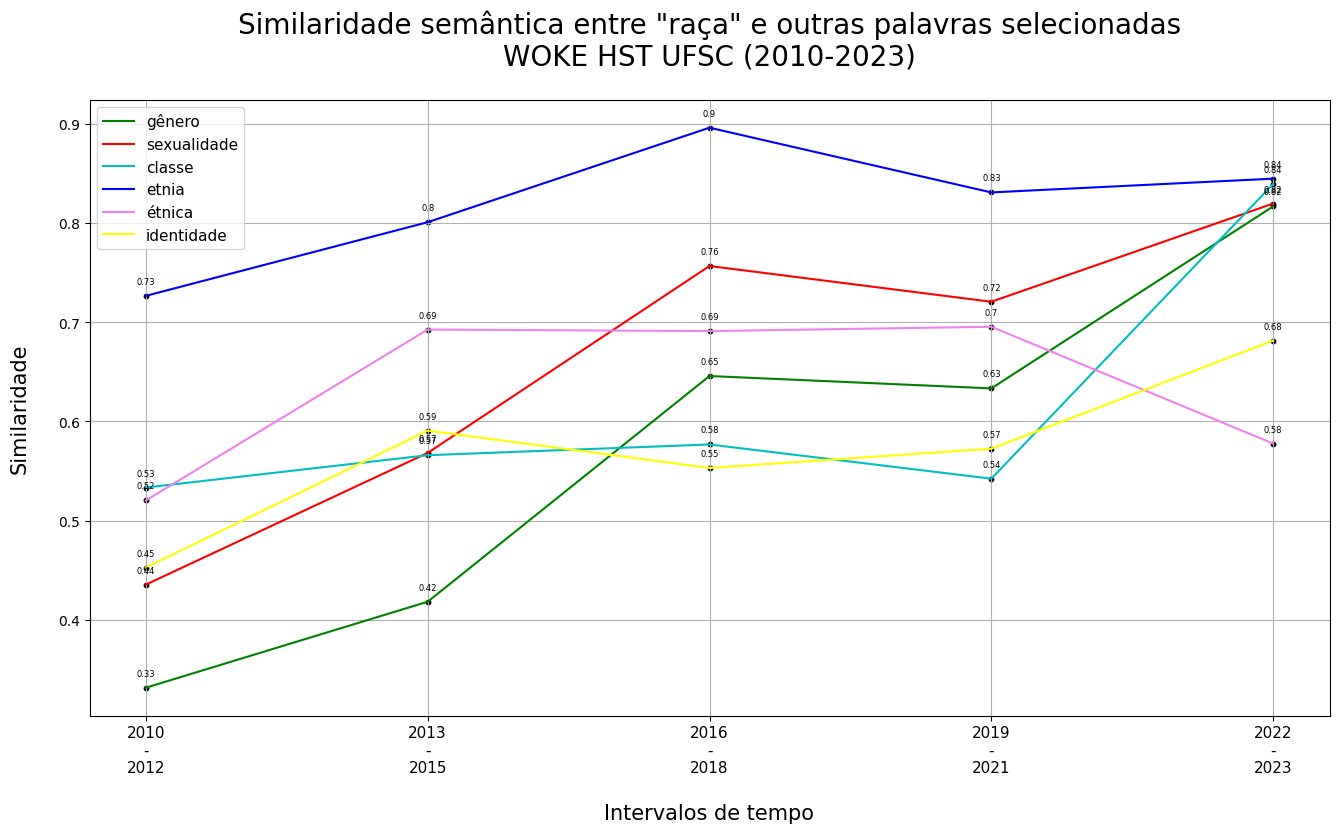

In [3]:
import matplotlib.pyplot as plt
import numpy as np



def verificaExistenciaNoModelo(modelos_treinados,palavra_central):
  try:
    for modelo in [modelo[1] for modelo in modelos_treinados]:
      modelo.wv.most_similar(palavra_central)
    return True
  except:
    return False


palavra_central = input('Digite uma palavra: ')
if verificaExistenciaNoModelo(modelos_treinados,palavra_central):

  cores = ['green','red','c','blue','violet','yellow','orange','black','purple']


  lista_palavras_comparacao = []
  while True:
    if len(lista_palavras_comparacao) < len(cores):
      palavra_digitada = input(f'\nDigite uma palavra para ser comparada (no máximo {len(cores)} e 0 para parar):  ')
      if (palavra_digitada != '0') and verificaExistenciaNoModelo(modelos_treinados,palavra_digitada):
        lista_palavras_comparacao.append(palavra_digitada)
      elif (verificaExistenciaNoModelo(modelos_treinados,palavra_digitada) == False) and (palavra_digitada != '0'):
        while (verificaExistenciaNoModelo(modelos_treinados,palavra_digitada) == False) and (palavra_digitada != '0'):
          palavra_digitada = input(f'Ocorreu um erro com "{palavra_digitada}".\nPor favor, digite outra:  ')
        lista_palavras_comparacao.append(palavra_digitada)
      else:
        break
    else:
      break



  nomes = [modelo[0].replace('_','\n-\n') for modelo in modelos_treinados]

  fig, ax = plt.subplots(figsize=(16, 8))

  x = [i+1 for i in range(len(modelos_treinados))]

  cores_usadas = []
  for palavra in lista_palavras_comparacao:
    i = 0
    cor = cores[i]
    while cor in cores_usadas:
      cor = cores[i+1]
      i += 1
    cores_usadas.append(cor)
    y = []
    for modelo in [modelo[1] for modelo in modelos_treinados]:
      y.append(modelo.wv.similarity(palavra_central,palavra))

    ax.scatter(x, y, color='black', s=10)
    line_x = [x[0]] + x[1:-1] + [x[-1]]
    line_y = [y[0]] + y[1:-1] + [y[-1]]
    ax.plot(line_x, line_y, label=palavra, color=cor)
    for i in range(len((y))):
      ax.text(x[i], y[i]+0.01, str(round(y[i],2)), fontsize=6, ha='center', va='bottom')


  ax.set_title(f'Similaridade semântica entre "{palavra_central}" e outras palavras selecionadas\nWOKE HST UFSC (2010-2023)', fontsize=20, pad= 25)
  ax.set_xlabel('Intervalos de tempo', fontsize=15, labelpad=20)
  ax.set_ylabel('Similaridade', fontsize=15, labelpad=20)

  ax.set_xticks(x)
  ax.set_xticklabels(nomes,fontsize=11)

  # ax.set_yticks(lista_eixo_y)
  # ax.set_yticklabels(lista_eixo_y,fontsize = 11)
  ax.grid('on')

  ax.legend(fontsize = 11)
  # plt.savefig(f'Distancia com o tempo para palavra {palavra_central}.jpg', dpi=300, bbox_inches='tight')
  output.clear()
  plt.show()
else:
  print(f'{palavra_central} não foi encontrada no vocabulário de todos os modelos...')

#Campo semântico

In [ ]:
import time
import joblib
import os
from random import randint, random
import sys
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np


def verificaExistenciaNoModelo(modelo_escolhido,palavra_central):
  existe = False
  while not existe:
    try:
      modelo_escolhido.wv.most_similar(palavra_central)
    except:
      existe = False
      palavra_central = input(f'Ocorreu um erro com "{palavra_central}".\nPor favor, digite outra palavra: ')
    else:
      existe = True
  return palavra_central

def campoSemantico(nome_modelo_escolhido,modelo_escolhido, palavra):
  try:
    output.clear()
    if palavra == '':
      palavra_central = input(f'Digite uma palavra para construir o campo semântico: ')
      palavra_central = verificaExistenciaNoModelo(modelo_escolhido,palavra_central)
    else:
      palavra_central = palavra
      # palavra_central = verificaExistenciaNoModelo(modelo_escolhido,palavra_central)

    output.clear()

    palavras_vizinhas = modelo_escolhido.wv.most_similar(palavra_central)

    palavras_vizinhas = []
    palavras_vizinhas_com_similaridade= []

    for palavra in modelo_escolhido.wv.most_similar(palavra_central):
      palavras_vizinhas.append(palavra[0])
      palavras_vizinhas_com_similaridade.append((palavra[0],palavra[1]))


    fig, ax = plt.subplots(1, 2,figsize=(12, 5),gridspec_kw={'width_ratios': [4, 1]})

    ax[0].axis('off')
    ax[1].axis('off')

    ax[0].text(0.5, 0.5, palavra_central, ha='center', va='center', fontsize=14, fontweight='bold')

    num_vizinhas = len(palavras_vizinhas)

    theta = np.linspace(0, 2 * np.pi, num_vizinhas, endpoint=False)
    raio = 0.1

    x_vizinhas = 0.5 + raio * np.cos(theta)
    y_vizinhas = 0.5 + raio * np.sin(theta)

    distancia_raio = 0.7

    for i, palavra in enumerate(palavras_vizinhas):
        ax[0].text(x_vizinhas[i], y_vizinhas[i], palavra, ha='center', va='center', fontsize=12, fontweight='bold')

        x_inicio = x_vizinhas[i] + (0.5 - x_vizinhas[i]) * distancia_raio
        y_inicio = y_vizinhas[i] + (0.5 - y_vizinhas[i]) * distancia_raio
        x_fim = x_vizinhas[i]
        y_fim = y_vizinhas[i]

        ax[0].plot([x_inicio, x_fim], [y_inicio, y_fim], color='gray')

    ax[0].set_title(f'Campo semântico com 10 palavras mais próximas de {palavra_central}\nWOKE HST {nome_modelo_escolhido}')

    texto = "Resultado:\n('palavra', similaridade)"
    for i in range(len(palavras_vizinhas_com_similaridade)):
      texto += '\n\n'+str(palavras_vizinhas_com_similaridade[i])

    ax[1].text(1, 0.5,texto, fontsize=11, ha='center', va='center')

    # plt.show()
    try:
      os.makedirs(f'/content/{palavra_central}')
    except:
      pass
    plt.savefig(f'/content/{palavra_central}/Campo semântico de {palavra_central} usando {nome_modelo_escolhido}.png', dpi=300, bbox_inches='tight')
    print(f'\n\n\tImagem salva com sucesso para {nome_modelo_escolhido}!\n\n')
  except:
    output.clear()
    print(f'Ocorreu um erro com a palavra {palavra}...')
    erro = f'Na função: campoSemantico, usando {nome_modelo_escolhido}.\nDescrição do erro --> '+str(sys.exc_info()[0].__name__)+": "+str(sys.exc_info()[1])+'.'
    with open('Problemas durante execução.txt','a',encoding='utf-8') as f:
      f.write(erro+'\n\n')
      f.close()
  time.sleep(3)
  plt.clf()
  output.clear()


palavra = input('Digite uma palavra para contruir campo semântico: ')
for modelo in modelos_treinados:
  campoSemantico(modelo[0],modelo[1],palavra)
output.clear()
print('\n\n\tImagens salvas com sucesso!\n\n')



	Imagens salvas com sucesso!




<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

#Heat Map

##Mapa de calor CAMPO SEMÂNTICO

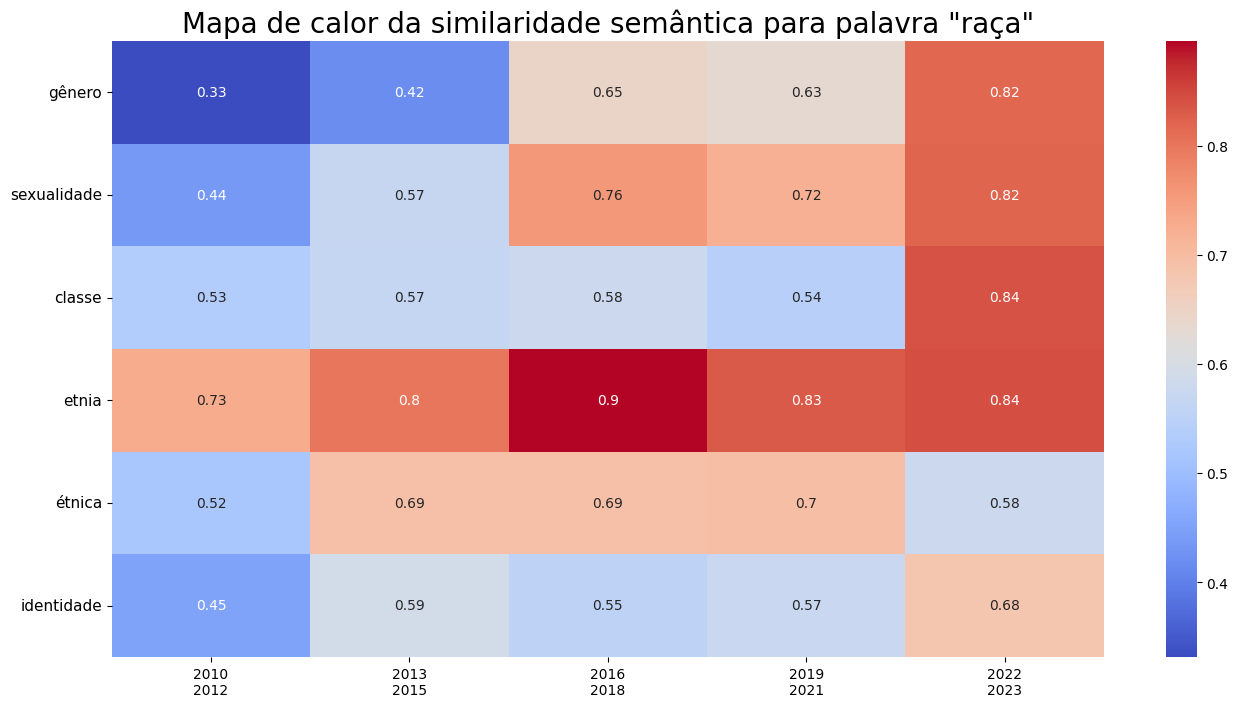

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def verificaExistenciaNosModelos(palavra,modelos_treinados):
  try:
    for modelo in modelos_treinados:
      modelo[1].wv.get_vector(palavra)
    return True
  except:
    print('\nDescrição do erro --> '+str(sys.exc_info()[0].__name__)+": "+str(sys.exc_info()[1])+'.')
    return False

palavras_selecionadas = []

palavra_central = input('Digite a palavra central: ')

while not verificaExistenciaNosModelos(palavra_central,modelos_treinados):
  palavra_central = input(f'\nOcorreu um erro com "{palavra_central}". \nPor favor, digite outra palavra: ')

while True:
  palavra_digitada = input('Digite a palavra para ser comparada com a palavra central (0 para parar): ')
  if palavra_digitada != '0':
    palavras_selecionadas.append(palavra_digitada)
  else:
    break


data = {}

for modelo in modelos_treinados:
  dic_comparativo = {}
  for palavra_selecionada in palavras_selecionadas:
    try:
      dic_comparativo[palavra_selecionada] = modelo[1].wv.similarity(palavra_central,palavra_selecionada)
    except:
      dic_comparativo[palavra_selecionada] = 0
  data[modelo[0].replace('_','\n')] = dic_comparativo


df = pd.DataFrame(data)

plt.figure(figsize=(16, 8))
heatmap = sns.heatmap(df, annot=True, cmap='coolwarm')

heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=0)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0,fontsize=11)


plt.title(f'Mapa de calor da similaridade semântica para palavra "{palavra_central}"',fontsize=20)
# plt.ylabel('Palavras')
# plt.xlabel('Intervalo de datas')
output.clear()

plt.show()

##Mapa de calor DIMENSÕES

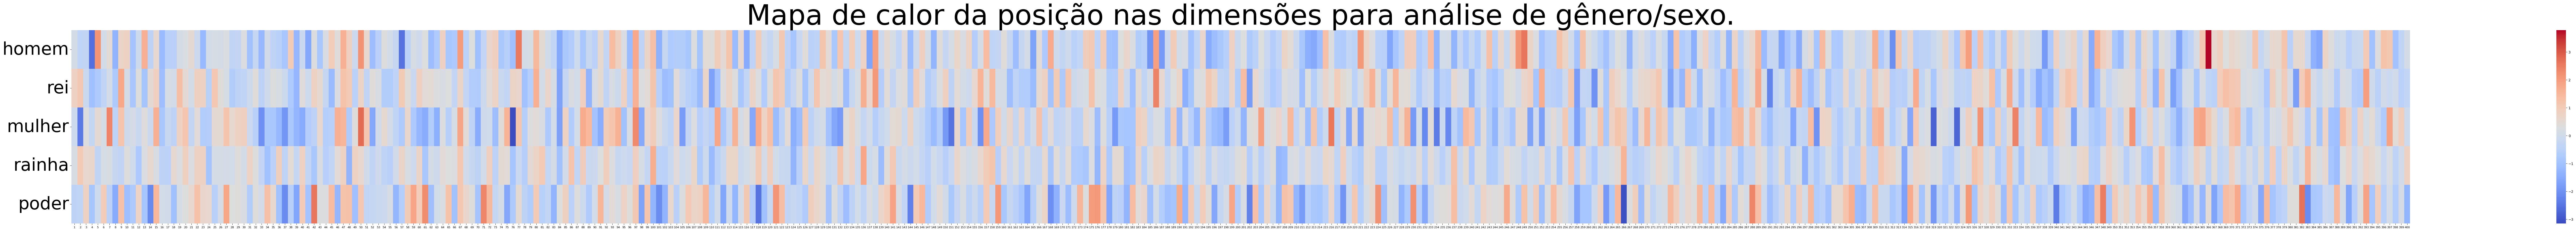

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#################### MUDANÇA DAS PALAVRAS AQUI ################################################################################

palavras_selecionadas = ['homem','rei','mulher','rainha','poder']#,'garoto','garota'


#################### CÓDIGO PARA GERAÇÃO DA IMAGEM ABAIXO ################################################################################


data = {}

modelo = joblib.load('/content/drive/MyDrive/Programa - Repositório Institucional UFSC/Word Embeddings/Treinamento do nosso modelo/nonce2vec_woke_hst_cbow_400.joblib')

for i in range(400):
  dic_comparativo = {}
  for palavra_selecionada in palavras_selecionadas:
    try:
      dic_comparativo[palavra_selecionada] = modelo.wv.get_vector(palavra_selecionada)[i]
    except:
      dic_comparativo[palavra_selecionada] = 0
  data[i+1] = dic_comparativo

df = pd.DataFrame(data)

plt.figure(figsize=(150, 10))
heatmap = sns.heatmap(df, annot=False, cmap='coolwarm')

heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=0,fontsize=8)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0,fontsize=50)

plt.title(f'Mapa de calor da posição nas dimensões para análise de gênero/sexo.',fontsize=80)
# plt.ylabel('Palavras')
# plt.xlabel('Intervalo de datas')

plt.show()

#Planetary System of Words (representação sincrônica)

##Similaridade (pode-se ter o deslocamento do ponto central)

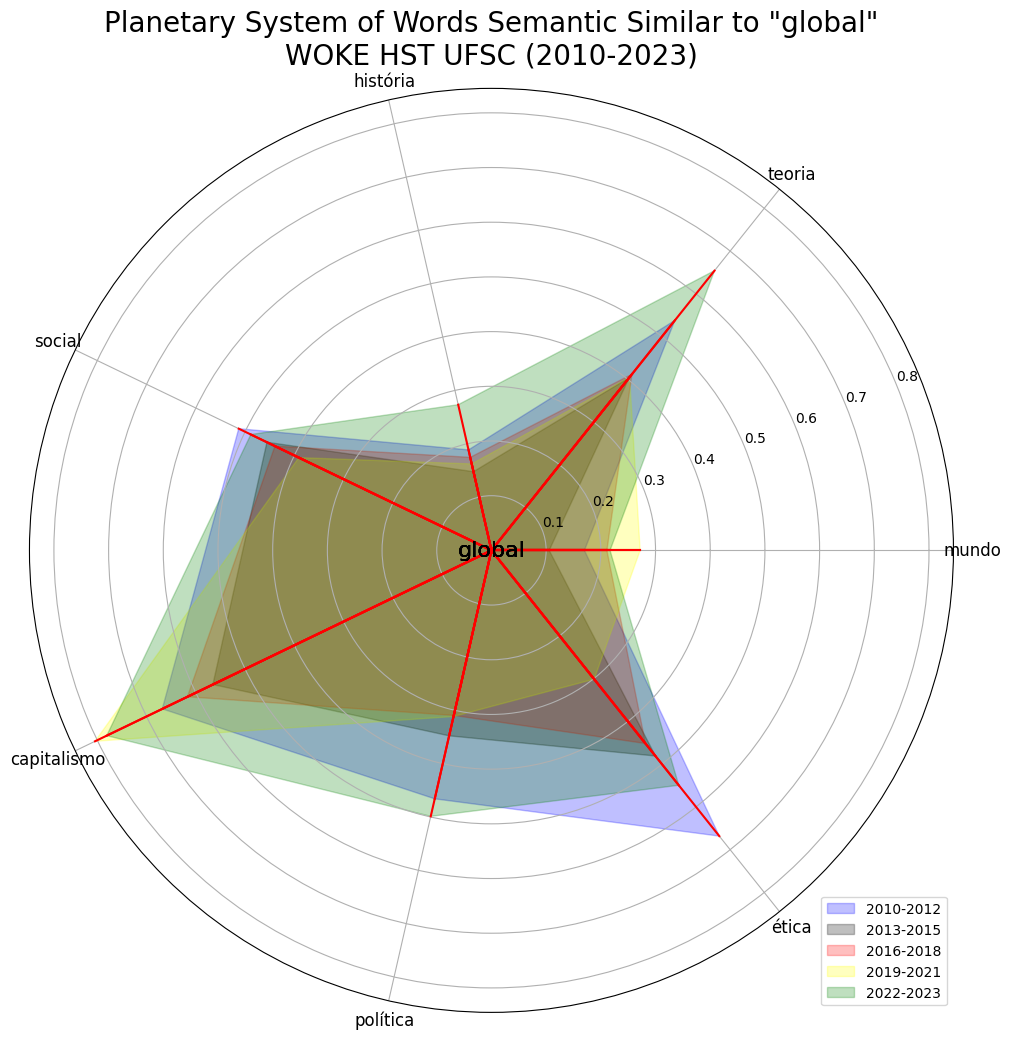

In [6]:
import matplotlib.pyplot as plt
import numpy as np


#################### MUDANÇA DAS PALAVRAS AQUI ################################################################################

palavra_central = 'global'
words = ['mundo', 'teoria', 'história','social','capitalismo','política','ética']


#################### CÓDIGO PARA GERAÇÃO DA IMAGEM ABAIXO ################################################################################



cores_usadas = []
cores = ['blue','black','red','yellow','green','c','pink','orange','grey','purple']


fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': 'polar'})

for modelo in modelos_treinados:
  scores = []  # Scores corresponding to the words
  for palavra in words:
    try:
      scores.append(modelo[1].wv.similarity(palavra_central,palavra))
    except:
      scores.append(0)

  # Preparing the plot
  angles = np.linspace(0, 2 * np.pi, len(words), endpoint=False).tolist() # Mudar de 0 para o valor mais baixo da similaridade (incluindo números negativos)
  scores += scores[:1]  # Ensuring the graph is circular
  angles += angles[:1]

  i = 0
  cor = cores[i]
  while (cor in cores_usadas) and (i < len(cores)):
    cor = cores[i+1]
    i += 1
  cores_usadas.append(cor)

  # Plotting
  ax.fill(angles, scores, color=cor,label=modelo[0].replace('modelo','').replace('_',' ').strip().replace(' ','-'), alpha=0.25)
  ax.set_xticks(angles[:-1])
  ax.set_xticklabels(words,fontsize=12)

  # Drawing lines from the center (AI) to each word
  for angle, score in zip(angles, scores):
      ax.plot([0, angle], [0, score], color='red')
  ax.text(0, 0, palavra_central, horizontalalignment='center', verticalalignment='center', size=16)


# Setting the title and the central label
ax.set_title(f'Planetary System of Words Semantic Similar to "{palavra_central}"\nWOKE HST UFSC (2010-2023)', size=20)


# Adding legend
ax.legend(loc='lower right')#

plt.show()

##Distância (centralidade garantida)

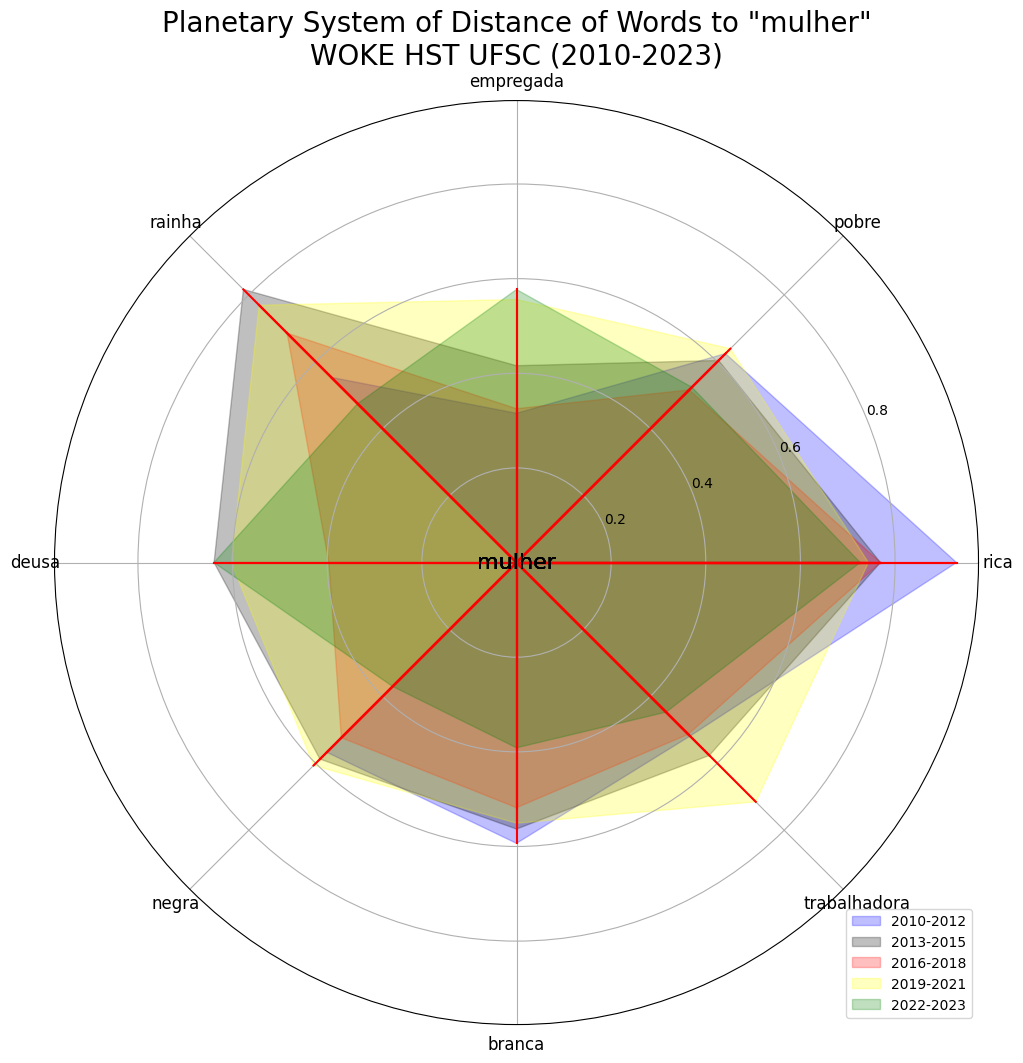

In [7]:
import matplotlib.pyplot as plt
import numpy as np


#################### MUDANÇA DAS PALAVRAS AQUI ################################################################################

palavra_central = 'mulher'
words = ['rica','pobre', 'empregada', 'rainha','deusa','negra','branca','trabalhadora']

#################### CÓDIGO PARA GERAÇÃO DA IMAGEM ABAIXO ################################################################################



cores_usadas = []
cores = ['blue','black','red','yellow','green','c','pink','orange','grey','purple']


fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': 'polar'})

for modelo in modelos_treinados:
  scores = []  # Scores corresponding to the words
  for palavra in words:
    try:
      scores.append(modelo[1].wv.distance(palavra_central,palavra))
    except:
      scores.append(0)

  # Preparing the plot
  angles = np.linspace(0, 2 * np.pi, len(words), endpoint=False).tolist()
  scores += scores[:1]  # Ensuring the graph is circular
  angles += angles[:1]

  i = 0
  cor = cores[i]
  while (cor in cores_usadas) and (i < len(cores)):
    cor = cores[i+1]
    i += 1
  cores_usadas.append(cor)

  # Plotting
  ax.fill(angles, scores, color=cor,label=modelo[0].replace('modelo','').replace('_',' ').strip().replace(' ','-'), alpha=0.25)
  ax.set_xticks(angles[:-1])
  ax.set_xticklabels(words,fontsize=12)

  # Drawing lines from the center (AI) to each word
  for angle, score in zip(angles, scores):
      ax.plot([0, angle], [0, score], color='red')
  ax.text(0, 0, palavra_central, horizontalalignment='center', verticalalignment='center', size=16)


# Setting the title and the central label
ax.set_title(f'Planetary System of Distance of Words to "{palavra_central}"\nWOKE HST UFSC (2010-2023)', size=20)


# Adding legend
ax.legend(loc='lower right')#

plt.show()

#Dynamic network visualization

##NETWORKX

###Plot oficial

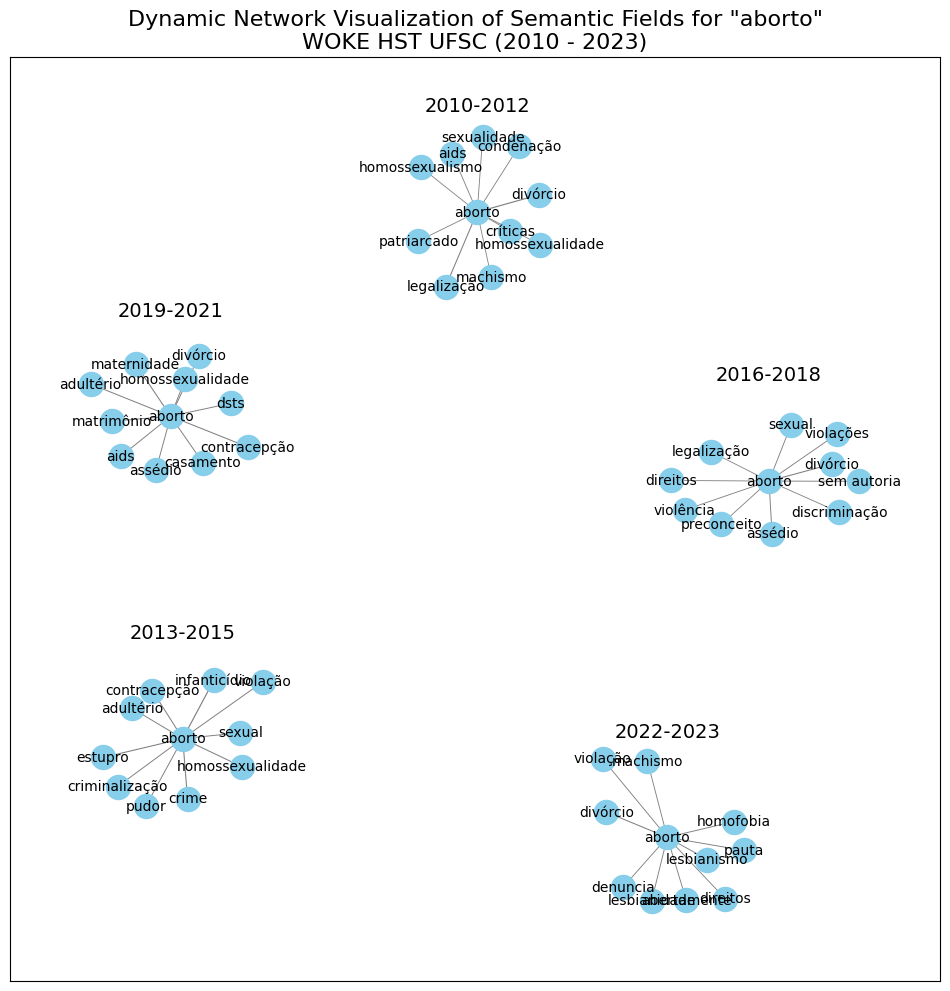

In [8]:
import matplotlib.pyplot as plt
import networkx as nx


#################### MUDANÇA DA PALAVRA CENTRAL AQUI ################################################################################

palavra_central = 'aborto'


#################### CÓDIGO PARA GERAÇÃO DA IMAGEM ABAIXO ################################################################################



# Create a new graph for dynamic network visualization
G = nx.Graph()

# Function to add nodes and edges to the graph for a specific year
def add_nodes_edges(data, year):
    # Add node for "AI" for the given year
    G.add_node(f"{palavra_central}_{year}")

    # Add nodes and edges based on TF-IDF scores
    for word, score in data.wv.most_similar(palavra_central, topn=10):
        G.add_node(f"{word}_{year}")
        G.add_edge(f"{palavra_central}_{year}", f"{word}_{year}", weight=score)

# Add nodes and edges for each year
for modelo in modelos_treinados:
  add_nodes_edges(modelo[1], modelo[0].replace('modelo','').replace('_',' ').strip().replace(' ','-'))

pos = nx.spring_layout(G, seed=42, scale=1, k=0.21, weight=1000)#

# Draw the graph
plt.figure(figsize=(12, 12))

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color="skyblue", node_size=300)

# Draw edges
weights = [G[u][v]['weight'] for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, width=weights, edge_color="grey")

# Draw labels
labels = {}
for node in G.nodes():
    labels[node] = node.split("_")[0]
nx.draw_networkx_labels(G, pos, labels, font_size=10)

# Add years as text labels above the clouds
for year in [modelo[0].replace('modelo','').replace('_',' ').strip().replace(' ','-') for modelo in modelos_treinados]:
    plt.text(pos[f"{palavra_central}_{year}"][0], pos[f"{palavra_central}_{year}"][1] + 0.25, year, fontsize=14, ha='center')

plt.title(f'Dynamic Network Visualization of Semantic Fields for "{palavra_central}"\nWOKE HST UFSC (2010 - 2023)',fontsize=16)
plt.show()

###Teste

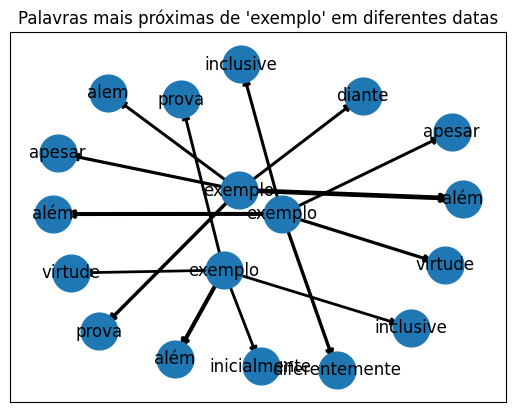

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Função para criar um gráfico de palavras mais próximas em diferentes datas
def plot_word2vec_network(word2vec_models, central_word, dates):
    # Criar um gráfico direcionado
    G = nx.DiGraph()

    # Adicionar nós e arestas para cada data
    for date, model in zip(dates, word2vec_models):
        similar_words = model.wv.most_similar(central_word, topn=5)
        G.add_node(f"{central_word}_{date}", label=central_word)
        for word, similarity in similar_words:
            G.add_node(f"{word}_{date}", label=word)
            G.add_edge(f"{central_word}_{date}", f"{word}_{date}", weight=similarity)

    # Configurar layout do gráfico
    pos = nx.spring_layout(G, seed=42)

    # Desenhar nós
    nx.draw_networkx_nodes(G, pos, node_size=700)

    # Desenhar arestas
    nx.draw_networkx_edges(G, pos, width=[G[u][v]['weight'] * 5 for u, v in G.edges])

    # Adicionar rótulos
    labels = {node: G.nodes[node]['label'] for node in G.nodes}
    nx.draw_networkx_labels(G, pos, labels)

    # Adicionar título
    plt.title(f"Palavras mais próximas de '{central_word}' em diferentes datas")

    # Exibir o gráfico
    plt.show()

# Exemplo de uso
# Suponha que você tenha modelos Word2Vec para diferentes datas
# Substitua word2vec_models e dates pelos seus próprios modelos e datas
word2vec_models = [modelos_treinados[0][1], modelos_treinados[1][1], modelos_treinados[2][1]]
dates = ["2021", "2022", "2023"]

# Palavra central
central_word = "exemplo"

# Chamar a função para gerar o gráfico
plot_word2vec_network(word2vec_models, central_word, dates)

##MATPLOTLIB

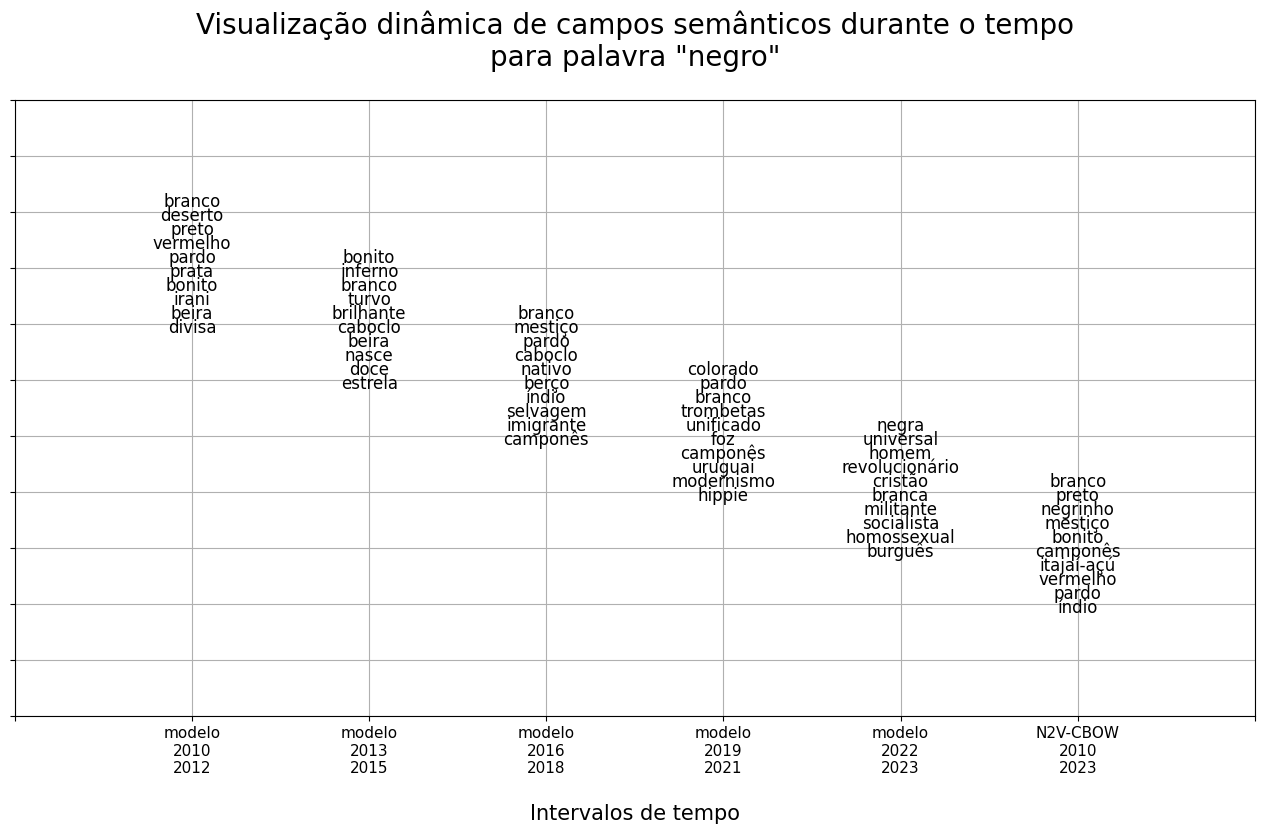

In [ ]:
import os
import joblib

caminho_geral = '/content/drive/MyDrive/Programa - Repositório Institucional UFSC/Word Embeddings/Treinamento do nosso modelo/Treinamento com temporalização/HST'

pasta_de_treinamento = '3 em 3 anos separando'

caminho = os.path.join(caminho_geral,pasta_de_treinamento)

modelos_treinados = []
modelos_treinados_armazenados = sorted([elemento for elemento in set(os.listdir(caminho)) if elemento.endswith('.joblib')])
for modelo in modelos_treinados_armazenados:
  modelos_treinados.append((modelo[:(len(modelo)-7)],joblib.load(os.path.join(caminho,modelo))))

modelos_treinados.append(('N2V-CBOW\n2010\n2023',joblib.load('/content/drive/MyDrive/Programa - Repositório Institucional UFSC/Word Embeddings/Treinamento do nosso modelo/nonce2vec_woke_hst_cbow_400.joblib')))

import matplotlib.pyplot as plt

nomes = []
nomes.append('')
for modelo in modelos_treinados:
  nomes.append(modelo[0].replace('_','\n'))
nomes.append('')

fig, ax = plt.subplots(figsize=(16, 8))

# x = list(range(1,len(modelos_treinados)+1))

palavra_central  = 'negro'
ymin = 100
yo = y = 8
for i,modelo in enumerate(modelos_treinados):
  top5 = modelo[1].wv.most_similar(palavra_central)#[0:5]
  x = (i+2)
  y = yo-(i+2)
  for resultado in (top5):
    ax.scatter(x, y, color='black', s=0)
    ax.text(x, y+0.025, resultado[0], ha = 'center', fontsize=12, va='bottom')
    y -= 0.25
    if y < ymin:
      ymin = y

ax.set_title(f'Visualização dinâmica de campos semânticos durante o tempo\npara palavra "{palavra_central}"', fontsize=20, pad= 25)
ax.set_xlabel('Intervalos de tempo', fontsize=15, labelpad=20)
# ax.set_ylabel('Campos semânticos', fontsize=15, labelpad=20)

ax.set_xticks(list(range(1,len(nomes)+1)))
ax.set_xticklabels(nomes,fontsize=11)
# ax.set_xlim([0, 15])  # Substitua pelos valores desejados

ax.set_yticks(list(range(int(ymin)-2,yo+1)))
ax.set_yticklabels('')

ax.grid('on')
# ax.yaxis.grid(False)
# ax.xaxis.grid(False)

# ax.legend(fontsize = 11)

# plt.savefig(f'Distancia com o tempo para palavra {palavra_central}.jpg', dpi=300, bbox_inches='tight')
plt.show()

# output.clear()

#Informação dos Modelos treinados selecionados

In [9]:
for model in modelos_treinados:
  print('\n',model[0],sep='\n')
  print('\ncorpus_count (QUANTIDADE DE FRASES):','{0:,}'.format(model[1].corpus_count).replace(',','.'))
  print('corpus_total_words (TOTAL DE TOKENS NO CORPUS):','{0:,}'.format(model[1].corpus_total_words).replace(',','.'))
  print('index_to_key (quantidade de palavras "únicas" no corpus,\ntambém chamado de vocabulário):','{0:,}'.format(len(model[1].wv.index_to_key)).replace(',','.'))
  print('Quantidade de palavras que foram para o treinamento','{0:,}'.format(sum(model[1].wv.get_vecattr(word, 'count') for word in model[1].wv.index_to_key)).replace(',','.'))



2010_2012

corpus_count (QUANTIDADE DE FRASES): 347.570
corpus_total_words (TOTAL DE TOKENS NO CORPUS): 3.394.011
index_to_key (quantidade de palavras "únicas" no corpus,
também chamado de vocabulário): 11.521
Quantidade de palavras que foram para o treinamento 2.719.647


2013_2015

corpus_count (QUANTIDADE DE FRASES): 468.195
corpus_total_words (TOTAL DE TOKENS NO CORPUS): 4.955.815
index_to_key (quantidade de palavras "únicas" no corpus,
também chamado de vocabulário): 15.419
Quantidade de palavras que foram para o treinamento 4.075.351


2016_2018

corpus_count (QUANTIDADE DE FRASES): 440.427
corpus_total_words (TOTAL DE TOKENS NO CORPUS): 4.754.708
index_to_key (quantidade de palavras "únicas" no corpus,
também chamado de vocabulário): 14.343
Quantidade de palavras que foram para o treinamento 3.953.547


2019_2021

corpus_count (QUANTIDADE DE FRASES): 413.595
corpus_total_words (TOTAL DE TOKENS NO CORPUS): 4.691.962
index_to_key (quantidade de palavras "únicas" no corpus,
també

#Modelo treinado com Rec. de Entidades 2010-2023 (selecione um e execute a célula abaixo dele)

###200D

In [13]:
modelo_atual = joblib.load('/content/drive/MyDrive/Programa - Repositório Institucional UFSC/Word Embeddings/Treinamento do nosso modelo/word2vec_woke_hst_c_RE_200.joblib')

###150D

In [10]:
modelo_atual = joblib.load('/content/drive/MyDrive/Programa - Repositório Institucional UFSC/Word Embeddings/Treinamento do nosso modelo/word2vec_woke_hst_c_RE_150.joblib')

###100D

In [ ]:
modelo_atual = joblib.load('/content/drive/MyDrive/Programa - Repositório Institucional UFSC/Word Embeddings/Treinamento do nosso modelo/word2vec_woke_hst_c_RE_100.joblib')

##Comparação entre palavras

In [ ]:
modelo_atual.wv.get_vector('raça')

In [40]:
modelo_atual.wv.most_similar(positive=['proletariado','burguesia'])

[('oligarquia', 0.6672912836074829),
 ('operariado', 0.6531099081039429),
 ('empresariado', 0.6512757539749146),
 ('aristocracia', 0.6478630304336548),
 ('capitalismo', 0.6113983988761902),
 ('liberalismo', 0.6097661256790161),
 ('socialista', 0.6086878180503845),
 ('hegemonia', 0.6079567074775696),
 ('liberal', 0.592424750328064),
 ('reformismo', 0.592108428478241)]

In [14]:
modelo_atual.wv.most_similar_cosmul(positive=['verdade','história'],negative=['jornalismo'])

[('lembrança', 1.125389814376831),
 ('sorte', 1.0363869667053223),
 ('eternidade', 1.0246093273162842),
 ('certeza', 1.0236175060272217),
 ('ilusão', 1.0233097076416016),
 ('veracidade', 1.0196846723556519),
 ('dor', 1.013327717781067),
 ('torá', 1.0115723609924316),
 ('humanidade', 1.0104641914367676),
 ('antepassados', 1.001997709274292)]

##Palavras mais próximas

In [ ]:
modelo_atual.wv.most_similar('jornalista',topn=15)

[('escritor', 0.7228348255157471),
 ('cronista', 0.6899827718734741),
 ('repórter', 0.689408540725708),
 ('colunista', 0.6640557646751404),
 ('redator', 0.6538838744163513),
 ('romancista', 0.650415301322937),
 ('colaborador', 0.6497640609741211),
 ('cartunista', 0.6494824290275574),
 ('editor', 0.649310290813446),
 ('literato', 0.6489009857177734),
 ('articulista', 0.6362838745117188),
 ('dramaturgo', 0.6165565848350525),
 ('pernambucano', 0.6134443879127502),
 ('economista', 0.613250195980072),
 ('memorialista', 0.6046777963638306)]